In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import os
from tensorflow.keras.preprocessing import image
import cv2

In [2]:
image_filenames = [i for i in os.listdir('UTKFace/')]

The test data is taken from UTKface dataset and this test data is not used for training any of the models and is only used for test purpose .The test split is obtained by holdout and using random_state to ensure no training data is used for training is used in testing.

**Reading the images**

In [3]:
ages=[]
genders=[]
# Iterate throuigh the filenames and for each one load the image, resize
count = len(image_filenames)
images=[]
images_emotion=[]
for i, image_file in enumerate(image_filenames):
        age=image_file.split('_')[0]
        gender=image_file.split('_')[1]
        image= cv2.imread('UTKFace/'+image_file,cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (200,200), interpolation=cv2.INTER_CUBIC) 
        if i%10000==0:
            print('Processed {} of {} images'.format(i + 1, count))
        ages.append(int(age))
        genders.append(int(gender))
        images.append(image)

Processed 1 of 23708 images
Processed 10001 of 23708 images
Processed 20001 of 23708 images


In [4]:
images_list = pd.Series(list(images),name='Images')
ages_list = pd.Series(list(ages),name='Age')
gender_list = pd.Series(list(genders),name='Gender')
df = pd.concat([images_list,ages_list,gender_list],axis=1)
df.head()

Images  Age  Gender
0  [[[215, 206, 201], [213, 204, 199], [212, 203,...  100       0
1  [[[118, 122, 133], [120, 124, 135], [122, 126,...  100       0
2  [[[219, 223, 226], [232, 235, 240], [232, 237,...  100       1
3  [[[78, 82, 93], [78, 82, 93], [78, 82, 93], [7...  100       1
4  [[[65, 69, 80], [66, 70, 81], [67, 71, 82], [6...  100       1

**Storing images to an array**

In [5]:
X = []
for i in range(len(df)):
    img = np.asarray(df['Images'].iloc[i])
    X.append(img)
X = np.array(X)

**Train test split**

In [6]:
from sklearn.model_selection import train_test_split
y_age = df['Age']
y_gender =df['Gender']
x_train, x_test, y_train_age, y_test_age = train_test_split(X, y_age, test_size=0.2,random_state=0)
x_train, x_test, y_train_gender, y_test_gender = train_test_split(X, y_gender, test_size=0.2,random_state=0)

In [7]:
actual_gen=[]
for i in y_test_gender:
    if i==0:
        actual_gen.append('Male')
    else:
        actual_gen.append('Female')

In [8]:
#Convert to series
images_list = pd.Series(list(x_test),name='Images')
actual_age = pd.Series(list(y_test_age),name='ActualAge')
actual_gender = pd.Series(list(actual_gen),name='ActualGender')
df = pd.concat([images_list,actual_age ,actual_gender],axis=1)
df.head()

Images  ActualAge ActualGender
0  [[[139, 109, 73], [139, 109, 73], [136, 106, 7...         40         Male
1  [[[52, 57, 37], [50, 55, 35], [48, 51, 32], [4...         36       Female
2  [[[15, 13, 16], [15, 13, 16], [15, 15, 17], [1...         75       Female
3  [[[140, 104, 92], [142, 106, 94], [145, 107, 9...         56         Male
4  [[[201, 153, 131], [201, 153, 131], [201, 153,...          1       Female

**Store the images for further use**

In [9]:
df.to_csv('ImagesOriginal.csv',index=False)

In [10]:
from tensorflow.keras.models import load_model
agemodel=load_model(r'age_model.h5')
emotionmodel=load_model(r'Emotion_model.h5')
gendermodel=load_model(r'gender_model.h5')

**Model Predictions for test data**

**Gender**

In [11]:
y_pred_gender = gendermodel.predict(x_test)
y_pred_gender =np.round(y_pred_gender)

In [12]:
y_pred_gen=[]
for i in y_pred_gender:
    if i==0:
        y_pred_gen.append('Male')
    else:
        y_pred_gen.append('Female')

In [13]:
df['Model_Pred_Gender']=y_pred_gen

**Age**

In [14]:
y_pred_age=[]

In [15]:
for i in x_test:
    i=i/255
    i=i.reshape(-1,200,200,3)
    y_pred_age.append(int(agemodel.predict(i)))

In [16]:
y_pred_age=np.asarray(y_pred_age).astype(int)

In [17]:
y_pred_age

array([47, 31, 67, ..., 34, 31, 21])

In [18]:
df['Model_Pred_Age']=y_pred_age

**Predict Emotion**

In [19]:
images_emotion=[]
for i, image_file in enumerate(image_filenames):
        gender=image_file.split('_')[1]
        image= cv2.imread('UTKFace/'+image_file,cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (48,48), interpolation=cv2.INTER_CUBIC) 
        if i%10000==0:
            print('Processed {} of {} images'.format(i + 1, count))
        images_emotion.append(image)

Processed 1 of 23708 images
Processed 10001 of 23708 images
Processed 20001 of 23708 images


In [20]:
x_train_emotion, x_test_emotion, y_train, y_test = train_test_split(images_emotion, y_age, test_size=0.2,random_state=0)

In [21]:
X_emotion = np.array(x_test_emotion)

In [22]:
#Predict emotion in test data
x_test_emotion=X_emotion/255
predlabels = emotionmodel.predict(x_test_emotion)
predlabels.argmax(axis=1)
predictions=predlabels.argmax(axis=1)

emotions={0:'angry',1:'disgust',2:'fear',3:'happy',4:'neutral',5:'sad',6:'surprise'}

y_pred_emotions=[]
for i in range(len(predictions)):
    y_pred_emotions.append(emotions[predictions[i]])

In [23]:
df['Model_Pred_Emotion']=y_pred_emotions

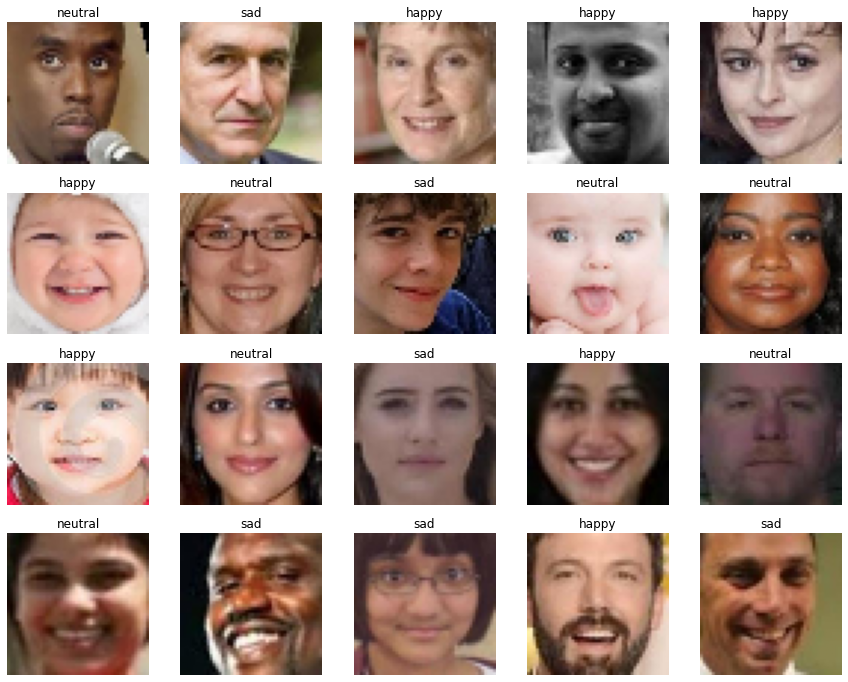

In [28]:
pltsize=3
row_images = 4
col_images = 5

maxtoshow = row_images * col_images
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i, image_file in enumerate(x_test_emotion):
    rand =random.randint(0,len(x_test_emotion))
    if ii>=maxtoshow:
        break
    else:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(x_test_emotion[rand])
        ii = ii + 1
        plt.title("{}".format(emotions[predictions[rand]]))

DeepFace is a face recognition model which was developed by Facebook researchers . The model was trained on labelled dataset of four million faces and the approach was based on a neural network of 9 layers.

This model has a  accuracy of 97.35% (+/- 0.25%) on the LFW dataset benchmark.DeepFace was sometimes predicted to be more successful than human beings when performing face recognition tasks.Age model got ± 4.65 MAE; gender model got 97.44% accuracy, 96.29% precision and 95.05% recall.
References :
https://viso.ai/computer-vision/deepface/

In [29]:
from deepface import DeepFace

In [31]:
DeepFace_emotion=[]
DeepFace_age=[]
DeepFace_gender=[]
for i, image_file in enumerate(x_test):
    rand =random.randint(0,len(x_test))
    result = DeepFace.analyze(image_file,enforce_detection=False)
    emotion=result['dominant_emotion']
    age=result['age']
    gender=result['gender']
    if gender=='Man':
        gen='Male'
    elif gender=='Woman':
        gen='Female'
    DeepFace_emotion.append(emotion)
    DeepFace_age.append(age)
    DeepFace_gender.append(gen)

Action: race: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]  


Action: race: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]   


Action: race: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]   


Action: race: 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]   


Action: race: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]   


Action: race: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]   


Action: race: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]   


Action: race: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]   


Action: race: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]   


Action: race: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]   


Action: race: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]   


Action: race: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]   


Action: race: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]   


Action: race: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]  


Action: race: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]   


Action: race: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]   


Action: race: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]   


Action: race: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]   


Action: race: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]   


<Figure size 1080x864 with 0 Axes>

In [45]:
df['DeepFaceGender']=DeepFace_gender
df['DeepFaceEmotion']=DeepFace_emotion
df['DeepFaceAge']=DeepFace_age

In [46]:
df.head()

Images  ActualAge ActualGender  \
0  [[[139, 109, 73], [139, 109, 73], [136, 106, 7...         40         Male   
1  [[[52, 57, 37], [50, 55, 35], [48, 51, 32], [4...         36       Female   
2  [[[15, 13, 16], [15, 13, 16], [15, 15, 17], [1...         75       Female   
3  [[[140, 104, 92], [142, 106, 94], [145, 107, 9...         56         Male   
4  [[[201, 153, 131], [201, 153, 131], [201, 153,...          1       Female   

  Model_Pred_Gender  Model_Pred_Age Model_Pred_Emotion DeepFaceGender  \
0              Male              47                sad           Male   
1            Female              31                sad           Male   
2            Female              67                sad           Male   
3              Male              51              happy           Male   
4              Male               0            neutral           Male   

  DeepFaceEmotion  DeepFaceAge  
0         neutral           28  
1         neutral           27  
2             sad           24  
3           happy           36  
4         neutral           26

**Storing the output in csv File**

In [47]:
df.to_csv('ImagesOriginal.csv',index=False)

In [48]:
df['DeepFaceGender'].value_counts()

Male      3696
Female    1046
Name: DeepFaceGender, dtype: int64

**Displaying predictions of Age with DeepFace**

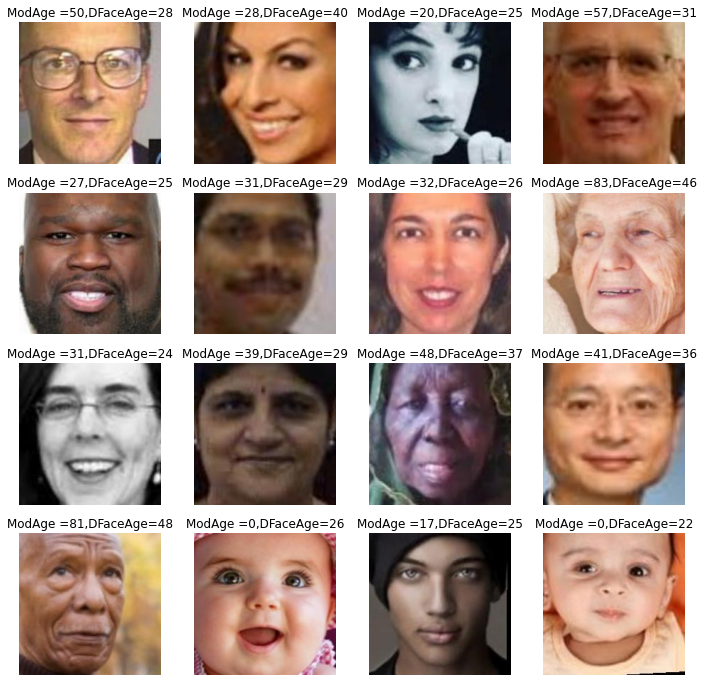

In [60]:
pltsize=3
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i, image_file in enumerate(x_test):
    rand =random.randint(0,len(x_test))
    if ii>=maxtoshow:
        break
    else:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(images_list[rand])
        ii = ii + 1
        plt.title("ModAge ={},DFaceAge={}".format(y_pred_age[rand],DeepFace_age[rand]))

**Displaying predictions of Gender with DeepFace**

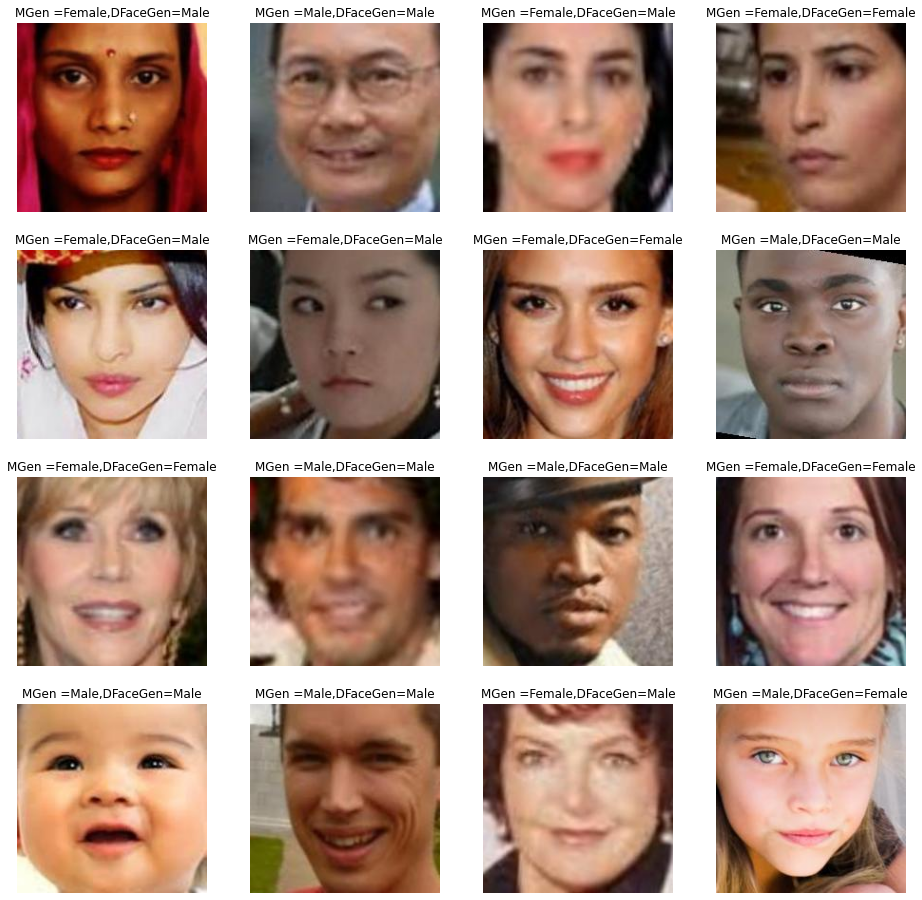

In [63]:
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i, image_file in enumerate(x_test):
    rand =random.randint(0,len(x_test))
    if ii>=maxtoshow:
        break
    else:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(images_list[rand])
        ii = ii + 1
        plt.title("MGen ={},DFaceGen={}".format(y_pred_gen[rand],DeepFace_gender[rand]))

**Displaying predictions of Emotions with DeepFace**

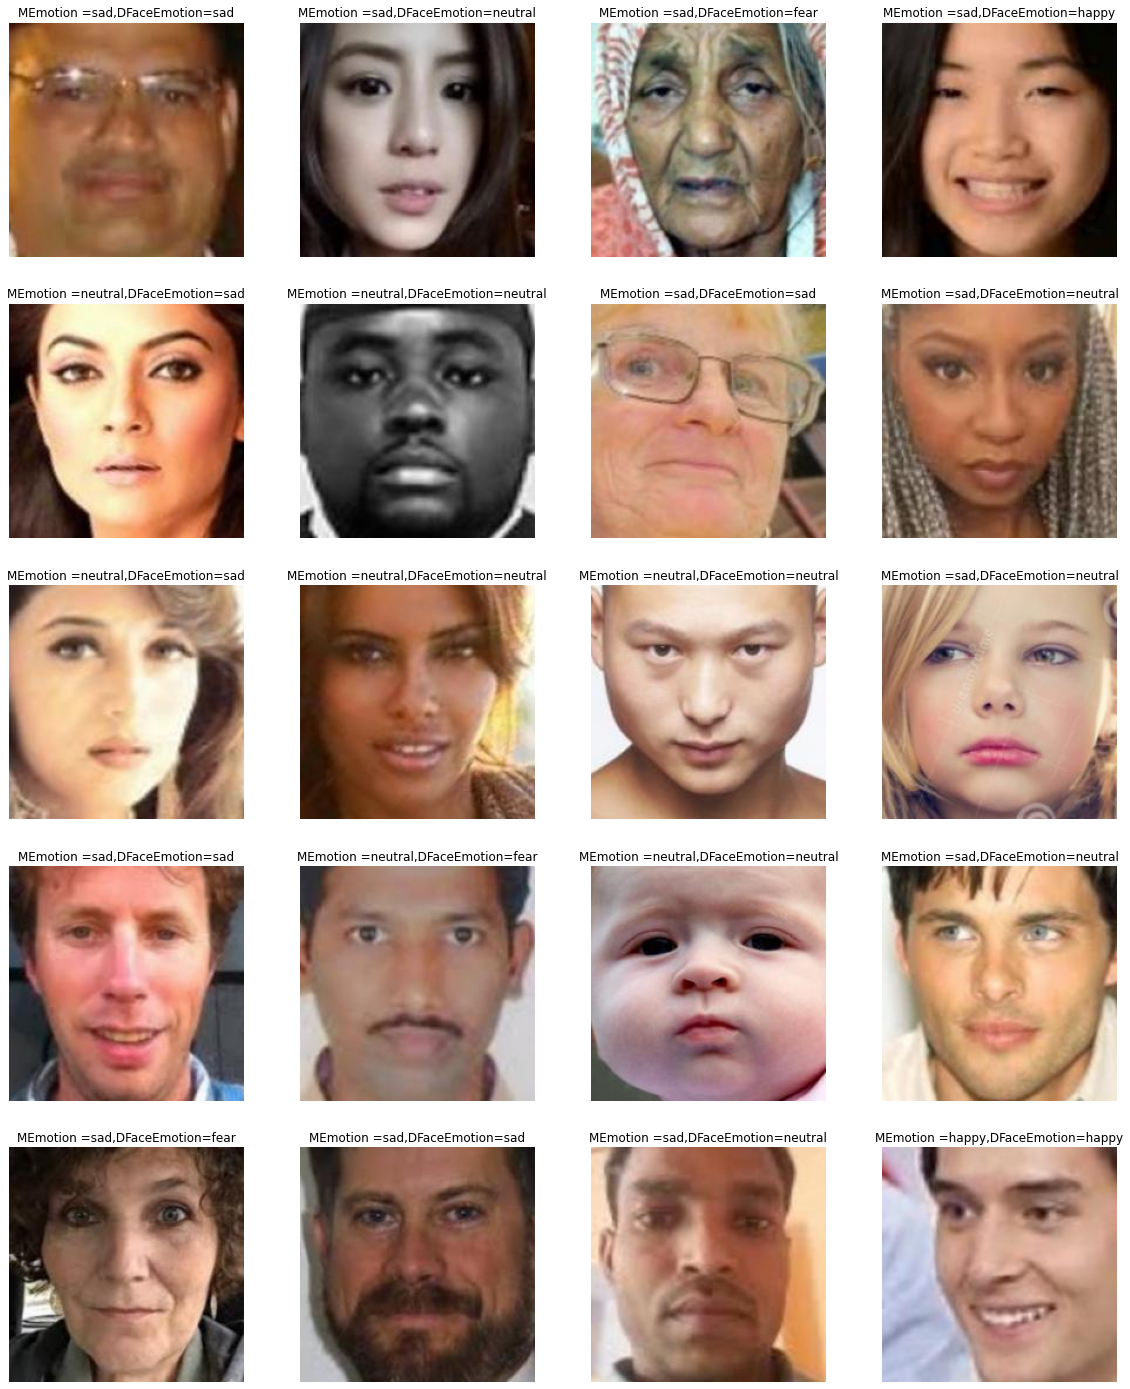

In [70]:
pltsize=5
row_images = 5
col_images = 4

maxtoshow = row_images * col_images
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i, image_file in enumerate(x_test):
    rand =random.randint(0,len(x_test))
    if ii>=maxtoshow:
        break
    else:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(images_list[rand])
        ii = ii + 1
        plt.title("MEmotion ={},DFaceEmotion={}".format(y_pred_emotions[rand],DeepFace_emotion[rand]))

The emotions are very well predicted for DeepFace compared to models trained manually.

The correlation between deepface age predictions and actual age data seems to be very less .Our model has a correlation of 80%

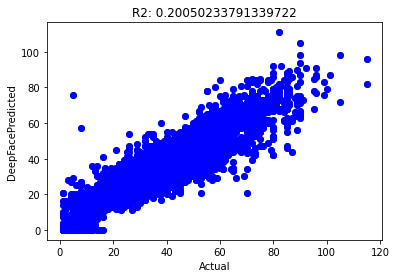

In [71]:
fig, ax = plt.subplots()
ax.scatter(y_test_age,y_pred_age)
ax.set_xlabel('Actual')
ax.set_ylabel('DeepFacePredicted')
plt.scatter(y_test_age,y_pred_age,color='blue')
ax.set_title('R2: ' + str(r2_score(y_test_age,DeepFace_age)))
plt.show()